In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import healpy as hp
from astropy.table import Table
from astropy.coordinates import SkyCoord, Angle
import astropy.units as u
import random
import os
import sys
sys.path.insert(0, '/home/aew492/lss-dipoles')
import tools
from Secrest_dipole import SecrestDipole
import dipole

### instantiate dipole object

In [3]:
d = SecrestDipole(initial_catfn='catwise_agns_master_masks.fits', 
                  catname='catwise_agns', mag='w1', maglim=16.4, blim=30)
d.cut_mag()
d.cut_galactic_plane()

loading initial catalog, catwise_agns_master_masks.fits
3136211 sources in initial catalog.
cut w1 > 16.4 -> 2698625 sources left.
cut |b| <= 30 -> 1355352 sources left.


### jackknife: leave out 1/12 random sources

In [4]:
# for jackknife, randomly divide the sources into N subsets

# get indices of the sources in the table, and shuffle in case the rows are organized in a particular way
idx = np.arange(len(d.table))
random.shuffle(idx)

# divide the table into nsamples
nsamples = 12
idx_samples = np.array_split(idx, nsamples)

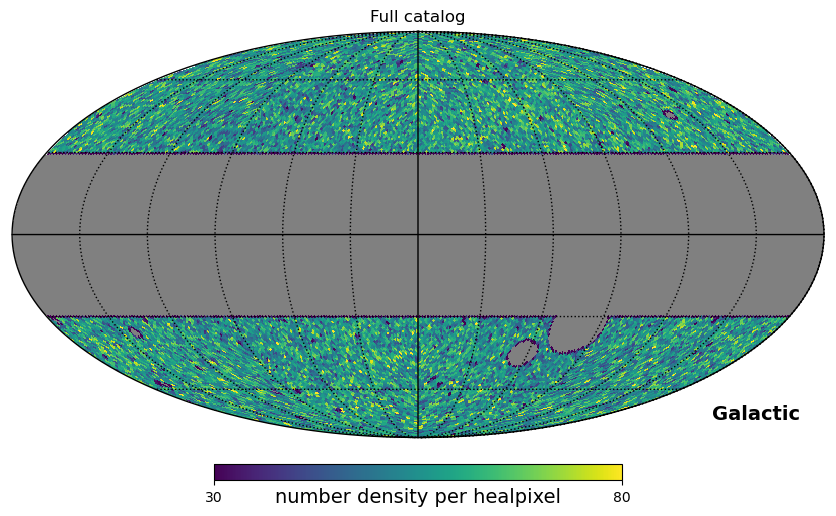

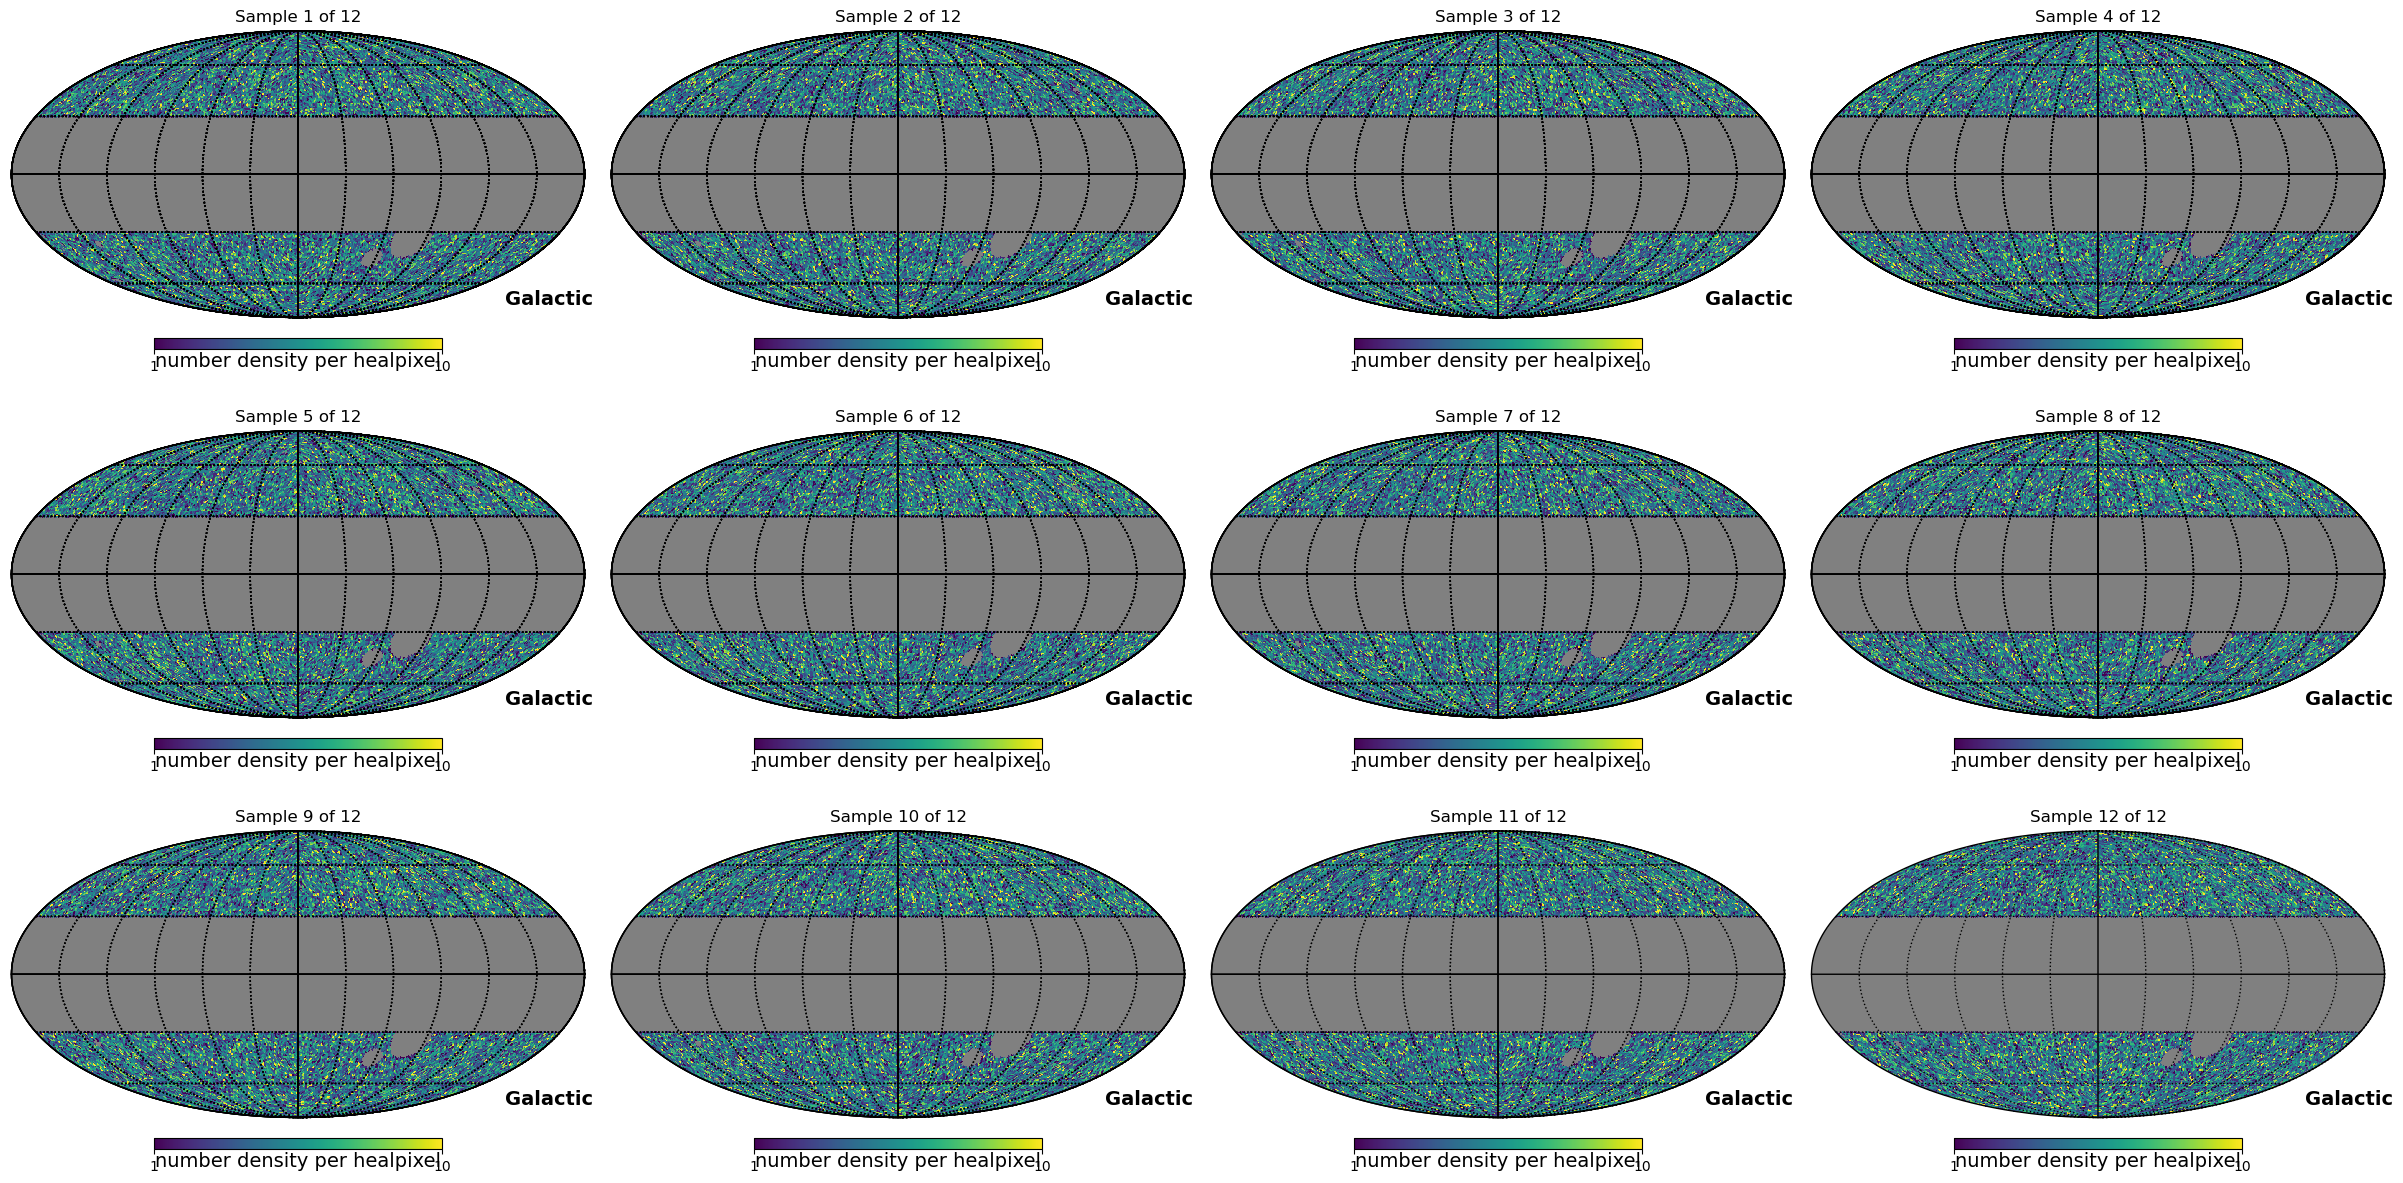

In [5]:
# make healpy map of each sample
NSIDE = 64
hpmap = tools.load_catalog_as_map(d.table[idx], frame='galactic', NSIDE=NSIDE)
hpmap[hpmap==0.] = np.nan
tools.mollview(hpmap, coord=['G'], min=30, max=80, title=f'Full catalog')

fig = plt.figure(figsize=(2 * nsamples, nsamples))
for i, idx_sample in enumerate(idx_samples):
    hpmap = tools.load_catalog_as_map(d.table[idx_sample], frame='galactic', NSIDE=NSIDE)
    hpmap[hpmap==0.] = np.nan
    tools.mollview(hpmap, coord=['G'], title=f'Sample {i+1} of {nsamples}',
                   min=1, max=10, sub=(nsamples//4,nsamples//3,i+1))

For each sample:

1. Convert source counts to healpixel densities.
2. Mask.
3. Make extra galactic plane cut (to avoid underdensities in pixels where only some sources were masked).
4. Density correct (though we've seen this has minimal impact on the recovered dipole).
5. Measure the dipole with `healpy.fit_dipole`.

In [6]:
def measure_dipole(t):
    # converts source table to a table of healpix densities with NPIX rows
    t = d._make_healpix_map(t)
    # mask healpixels with the bright galaxy + image artifacts masks from Secrest
    t = d._mask_initial_healpix_map(map_=t)
    # make extra galactic plane cut (to avoid underdensities in pixels that land on the boundary) 
    t = t[np.abs(t['b']) > (d.blim + 1)]
    # density correct: fit a line to density vs. ecliptic latitude
    t = d._hpx_vs_direction(tab=t)
    # measure the dipole: this is a wrapper for my lstsq function and matches healpy.fit_dipole when Cinv==None
    #  * this also adds the "raw" output amps (monopole + 3 dipole amps) as an attribute
    dipole_amp, dipole_dir = d.compute_dipole(t, Cinv=None)
    return dipole_amp, dipole_dir, t

(0.015156206751219696,
 <SkyCoord (Galactic): (l, b) in deg
     (240.96201347, 28.56779734)>)

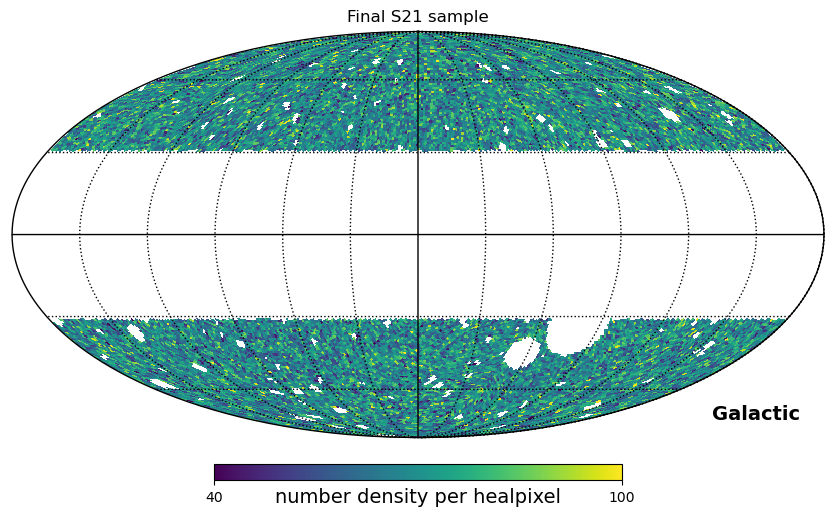

In [7]:
# measure dipole in the full sample
fullamp, fulldir, t = measure_dipole(d.table)
hpmap = np.empty(49152)
hpmap[:] = np.nan
hpmap[t['hpidx']] = t['elatdenscorr']
tools.mollview(hpmap, badcolor='w', coord=['C','G'], min=40, max=100, title='Final S21 sample')
fullamp, fulldir

In [8]:
# measure dipole in each LOO sample
compamps = np.empty((nsamples,4))
for i, idx_sample in enumerate(idx_samples):
    _, _, _ = measure_dipole(d.table[idx_sample])
    compamps[i] = d.amps

In [9]:
# amplitude and direction
amps = np.empty(nsamples)
lons = np.empty(nsamples)
lats = np.empty(nsamples)
for i, amps_ in enumerate(compamps):
    amps[i], dir_ = dipole.get_dipole(amps_, frame='icrs')
    lons[i] = dir_.galactic.l.rad
    lats[i] = dir_.galactic.b.rad

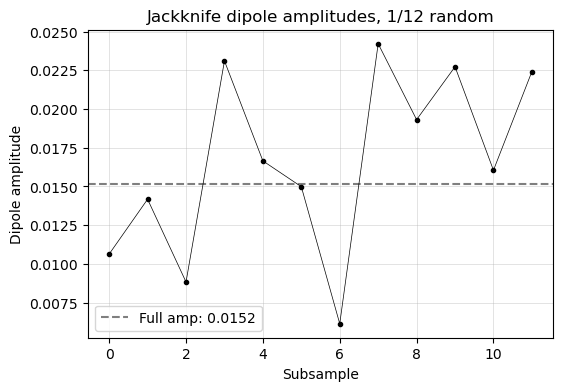

In [10]:
# overall amps
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(amps, 'k.-', lw=0.5)
ax.axhline(fullamp, c='k', alpha=0.5, ls='--', label=f'Full amp: {fullamp:.4f}')
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel('Subsample')
ax.set_ylabel('Dipole amplitude')
ax.set_title(f'Jackknife dipole amplitudes, 1/{nsamples} random')
ax.legend()

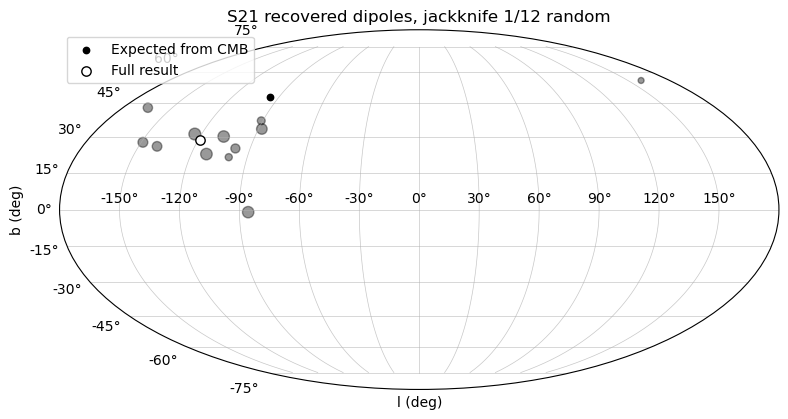

In [11]:
# sky plot
fig = plt.figure(figsize=(8,5))
ax = plt.subplot(111, projection='mollweide')

line_kwargs = dict(alpha=0.5, lw=0.5, marker='None')
kwargs = dict(marker='o', alpha=0.4)
a = 3000

# CMB
cmb_amp, cmb_dir = dipole.cmb_dipole(frame='galactic')
ax.scatter(Angle(cmb_dir.l.rad, unit=u.rad).wrap_at(np.pi*u.rad),
        Angle(cmb_dir.b.rad, unit=u.rad).wrap_at(np.pi*u.rad),
        marker='o', ls='None', s=a*cmb_amp, alpha=1., c='k', zorder=11, label='Expected from CMB')

# full result
ax.scatter(Angle(fulldir.l.rad, unit=u.rad).wrap_at(np.pi*u.rad),
           Angle(fulldir.b.rad, unit=u.rad).wrap_at(np.pi*u.rad),
           marker='o', c='w', edgecolors='k', s=a*fullamp, zorder=10, label='Full result')

# jackknife samples
# ax.plot(Angle(lons, unit=u.rad).wrap_at(np.pi*u.rad),
#         Angle(lats, unit=u.rad).wrap_at(np.pi*u.rad),
#         c='k', **line_kwargs)
im = ax.scatter(Angle(lons, unit=u.rad).wrap_at(np.pi*u.rad),
                 Angle(lats, unit=u.rad).wrap_at(np.pi*u.rad),
                 s=a*amps, c='k', **kwargs)

ax.set_xlabel('l (deg)')
ax.set_ylabel('b (deg)')
ax.legend()
ax.set_title(f'S21 recovered dipoles, jackknife 1/{nsamples} random')
ax.grid(True, lw=0.5, alpha=0.7)
fig.tight_layout()

In [12]:
# does the mean of the LOO results equal the result from the full sample?
np.mean(amps), fullamp
# no

(0.016600202869541714, 0.015156206751219696)

From the Jackknife wiki page: https://en.wikipedia.org/wiki/Jackknife_resampling

A jackknife estimate of the variance of some quantity $x$ is
$$
\mathrm{Var}(x)_\mathrm{jack} = \frac{n-1}{n} \sum_i^n (x_i - \bar x)^2
$$

where $n$ is the number of subsamples and $\bar x$ is the average result of the subsamples, $\bar x\equiv <x_i>_i$.

(This variance is different than the usual definition of sample variance because the jackknife subsamples are highly correlated!)

Also relevant is Eq. 38 in Hogg & Villar, Fitting very flexible models: https://arxiv.org/abs/2101.07256

In [13]:
def var_jackknife(Y):
    n = len(Y)
    if Y.ndim == 1:
        Y = Y[:,np.newaxis]
    Y_avg = np.nanmean(Y, axis=0)
    prefactor = (n-1) / n
    X = np.array([
        (Y[i] - Y_avg) @ (Y[i] - Y_avg).T for i in range(n)
    ])
    # return prefactor * np.sum([(x[i] - x_avg)**2 for i in range(n)])
    return prefactor * np.sum(X)

In [14]:
# dipole amplitudes relative to monopole
dipole_amps = np.array([amps_[1:] / amps_[0] for amps_ in compamps])
var_jackknife(dipole_amps)

0.0009380520425687229

In [15]:
# how does this compare to the jackknife variance of the overall amplitudes?
var_jackknife(amps)

0.0003604379076945812

In [16]:
# what's the relative uncertainty here?
var_jackknife(dipole_amps) / fullamp

0.06189227014161925

### jackknife: divide catalog into 12 longitude slices

In [17]:
# longitude bins
nsamples = 12
lonedges = np.linspace(0, 360, nsamples+1) << u.deg
lonavg = 0.5 * (lonedges[1:] + lonedges[:-1])

# galactic coordinates: get table indices of sources in each slice
assert 0 <= np.all(d.table['l']) <= 360
idx_to_drop = [
    ((d.table['l'] >= lonedges[i]) & (d.table['l'] < lonedges[i+1])) for i in range(nsamples)
]

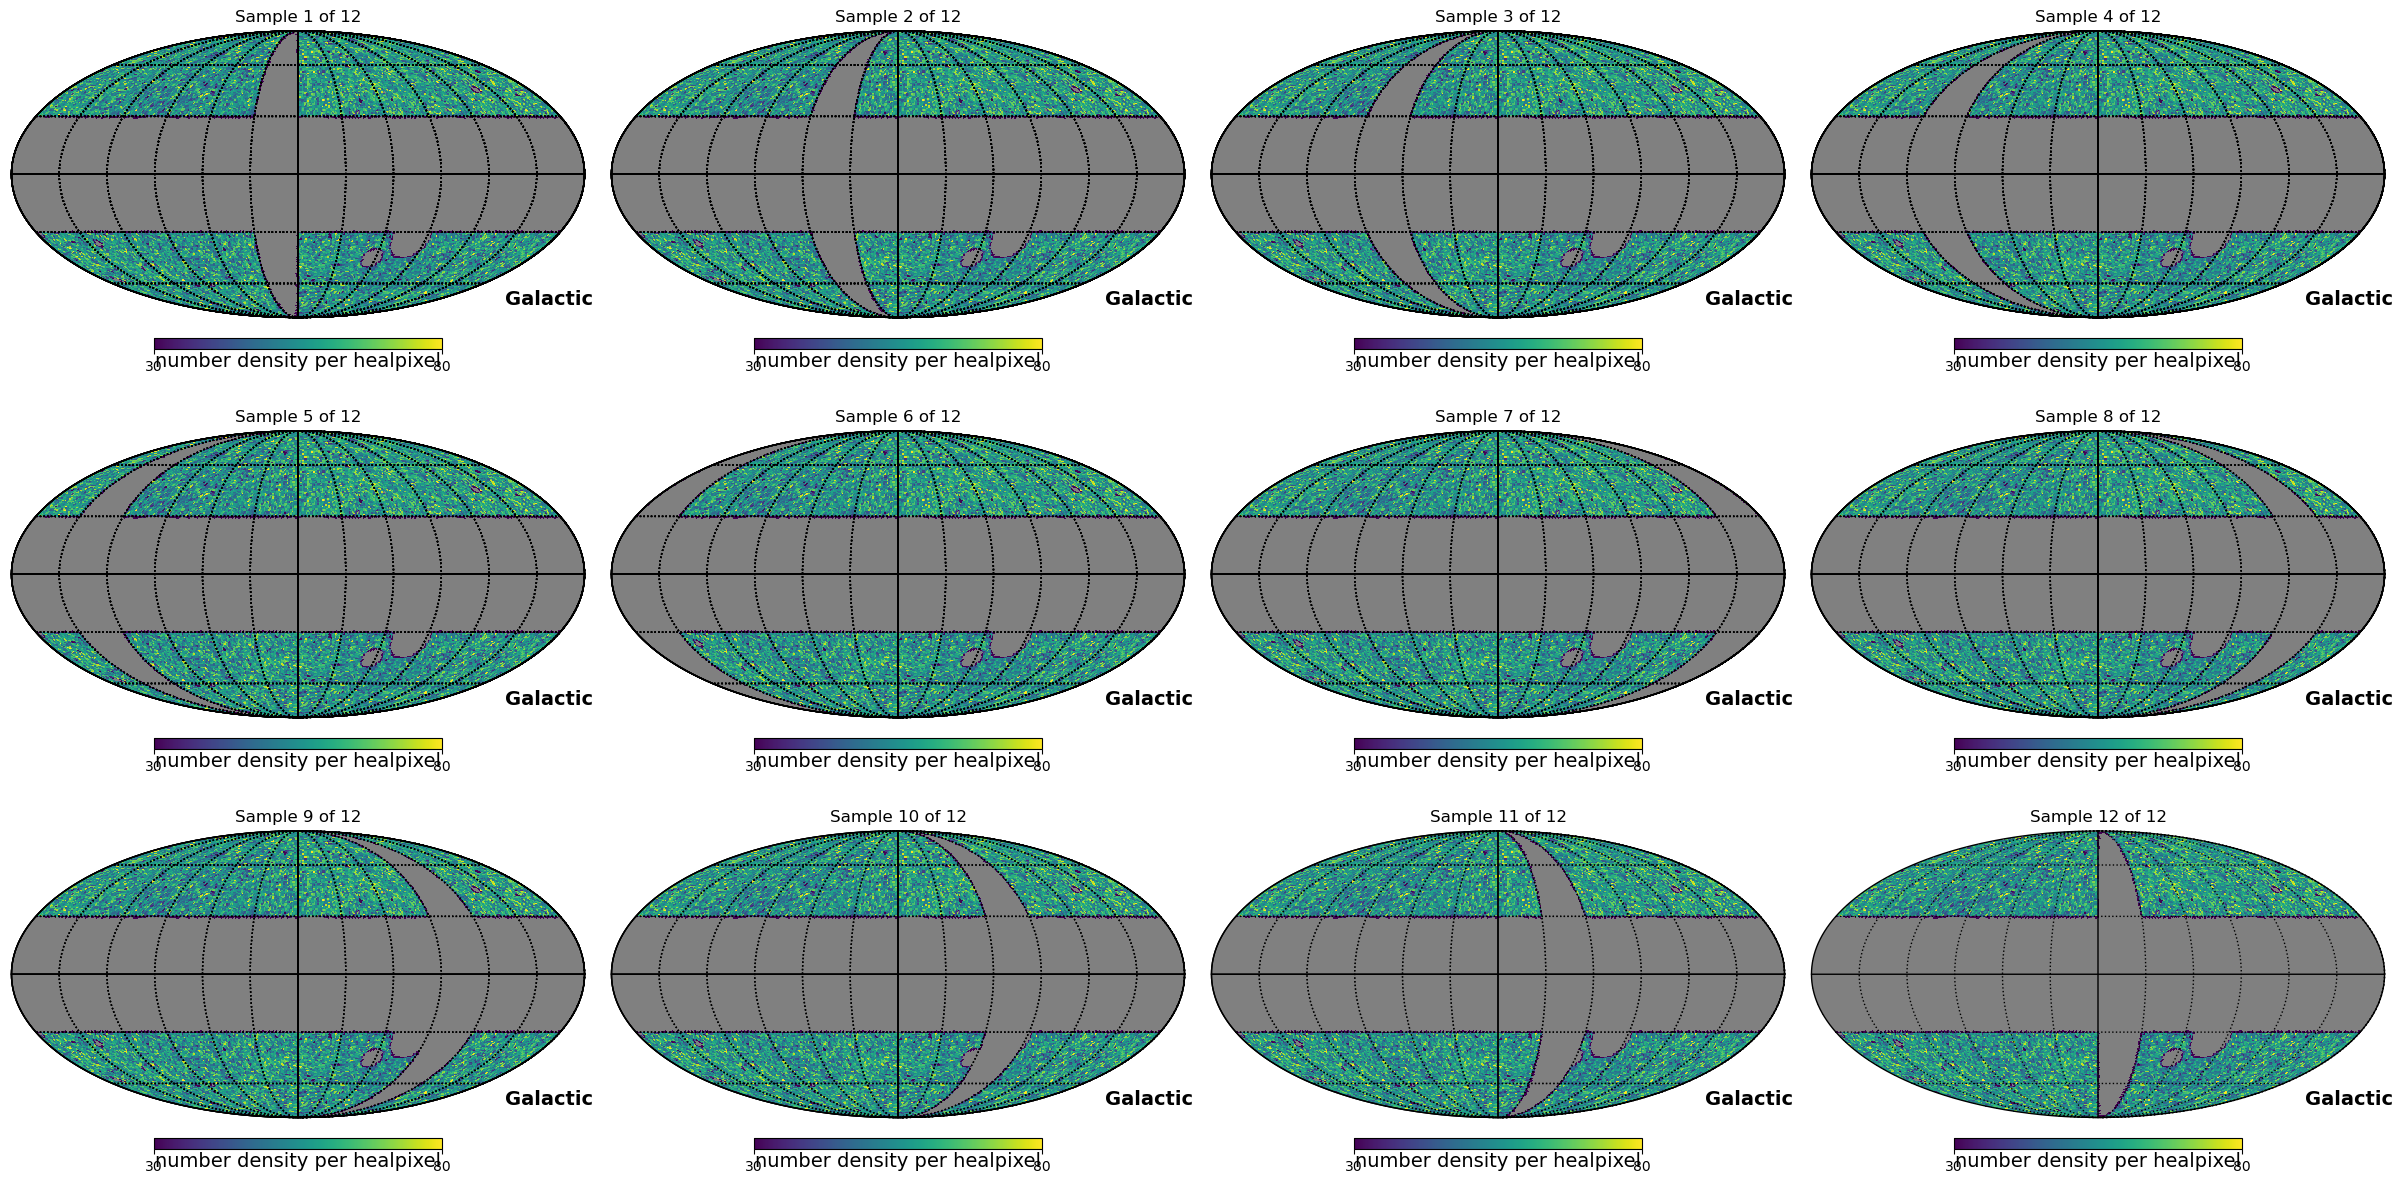

In [18]:
# make healpy map of each sample
NSIDE = 64
fig = plt.figure(figsize=(2 * nsamples, nsamples))
for i, idx in enumerate(idx_to_drop):
    hpmap = tools.load_catalog_as_map(d.table[~idx], NSIDE=NSIDE)
    hpmap[hpmap==0.] = np.nan
    tools.mollview(hpmap, coord=['C','G'], title=f'Sample {i+1} of {nsamples}',
                   min=30, max=80, sub=(nsamples//4,nsamples//3,i+1))

In [19]:
def measure_dipole(t, loncut=None):
    t = d._make_healpix_map(t)
    t = d._mask_initial_healpix_map(map_=t)
    # make extra galactic plane cut
    t = t[np.abs(t['b']) > (d.blim + 1)]
    if loncut is not None:
        # ** also make extra longitude cut now that we made a sharp cut at the source level
        idx_to_cut = (t['l']<<u.deg >= loncut[0] - 1*u.deg) & (t['l']<<u.deg < loncut[1] + 1*u.deg)
        t = t[~idx_to_cut]
    t = d._hpx_vs_direction(tab=t)
    # measure the dipole
    dipole_amp, dipole_dir = d.compute_dipole(t, Cinv=None)
    return dipole_amp, dipole_dir, t

In [20]:
# measure dipole in each LOO sample
compamps = np.empty((nsamples,4))
for i, idx in enumerate(idx_to_drop):
    _, _, _ = measure_dipole(d.table[~idx], loncut=lonedges[i:i+2])
    compamps[i] = d.amps

In [21]:
# amplitude and direction
amps = np.empty(nsamples)
lons = np.empty(nsamples)
lats = np.empty(nsamples)
for i, amps_ in enumerate(compamps):
    amps[i], dir_ = dipole.get_dipole(amps_, frame='icrs')
    lons[i] = dir_.galactic.l.rad
    lats[i] = dir_.galactic.b.rad

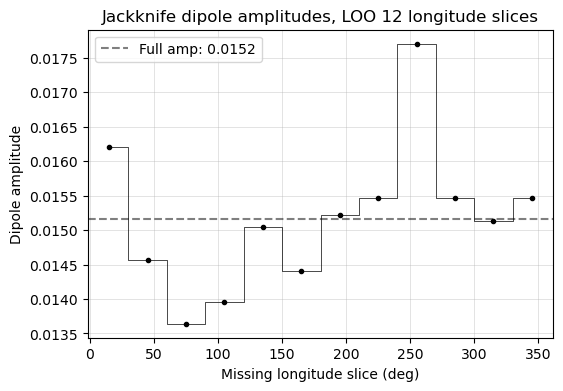

In [22]:
# overall amps
fig, ax = plt.subplots(figsize=(6,4))
# ax.plot(lonavg, amps, 'k.-', lw=0.5)
ax.step(lonavg, amps, 'k.-', lw=0.5, where='mid')
ax.axhline(fullamp, c='k', alpha=0.5, ls='--', label=f'Full amp: {fullamp:.4f}')
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel('Missing longitude slice (deg)')
ax.set_ylabel('Dipole amplitude')
ax.set_title(f'Jackknife dipole amplitudes, LOO {nsamples} longitude slices')
ax.legend()

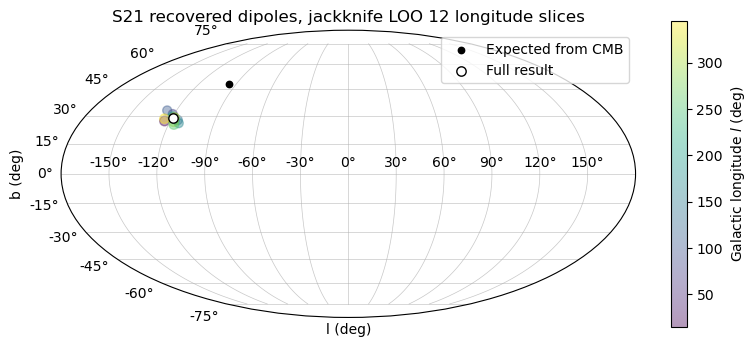

In [23]:
# sky plot
fig = plt.figure(figsize=(8,5))
ax = plt.subplot(111, projection='mollweide')

line_kwargs = dict(alpha=0.5, lw=0.5, marker='None')
kwargs = dict(marker='o', alpha=0.4)
a = 3000

# CMB
cmb_amp, cmb_dir = dipole.cmb_dipole(frame='galactic')
ax.scatter(Angle(cmb_dir.l.rad, unit=u.rad).wrap_at(np.pi*u.rad),
        Angle(cmb_dir.b.rad, unit=u.rad).wrap_at(np.pi*u.rad),
        marker='o', ls='None', s=a*cmb_amp, alpha=1., c='k', zorder=11, label='Expected from CMB')

# full result
ax.scatter(Angle(fulldir.l.rad, unit=u.rad).wrap_at(np.pi*u.rad),
           Angle(fulldir.b.rad, unit=u.rad).wrap_at(np.pi*u.rad),
           marker='o', c='w', edgecolors='k', s=a*fullamp, zorder=10, label='Full result')

# jackknife samples
# ax.plot(Angle(lons, unit=u.rad).wrap_at(np.pi*u.rad),
#         Angle(lats, unit=u.rad).wrap_at(np.pi*u.rad),
#         c='k', **line_kwargs)
im = ax.scatter(Angle(lons, unit=u.rad).wrap_at(np.pi*u.rad),
                 Angle(lats, unit=u.rad).wrap_at(np.pi*u.rad),
                 s=a*amps, c=lonavg.value, cmap='viridis', **kwargs)
cbar = fig.colorbar(im, ax=ax, shrink=0.65, aspect=20, fraction=.15, label=r'Galactic longitude $l$ (deg)')
ax.set_xlabel('l (deg)')
ax.set_ylabel('b (deg)')
ax.legend()
ax.set_title(f'S21 recovered dipoles, jackknife LOO {nsamples} longitude slices')
ax.grid(True, lw=0.5, alpha=0.7)
fig.tight_layout()

In [24]:
dipole_amps = np.array([amps_[1:] / amps_[0] for amps_ in compamps])
var_jackknife(dipole_amps)

2.2705584921010756e-05

In [25]:
# jackknife variance from the overall dipole amplitude in each subsample
var_jackknife(amps)

1.1470404212340549e-05

In [26]:
# what's the relative uncertainty here?
var_jackknife(dipole_amps) / fullamp

0.0014981047232800202